In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
from tqdm import tqdm
from scipy.special import softmax 
import torch.backends.cudnn as cudnn
import random
import pickle

In [2]:
import os
import shutil
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/My Drive/Colab Notebooks/cse559a/'
if not os.path.exists(checkpoints):
  os.makedirs(checkpoints)
  
if not os.path.exists('imagenet_val'):
  if not os.path.exists(checkpoints + 'imagenet_val.tar'):
    print("Downloading archive...")
    os.chdir(checkpoints)
    !wget -nv -O imagenet_val.tar -L https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar
    os.chdir('/content/')
  print("Copying to local runtime...")
  shutil.copy(checkpoints + 'imagenet_val.tar', './imagenet_val.tar')
  print("Uncompressing...")
  !mkdir imagenet_val
  !tar -xf imagenet_val.tar -C ./imagenet_val/
  !rm imagenet_val.tar
  os.chdir('./imagenet_val') 
  !wget -qO- https://raw.githubusercontent.com/soumith/imagenetloader.torch/master/valprep.sh | bash
  os.chdir('/content/')
print("Data ready!")

if not os.path.exists('exp_v0.py'):
  shutil.copy(checkpoints + 'exp_v0.py', './exp_v0.py')
  print("File imported")
from exp_v0 import *

Mounted at /content/drive
Copying to local runtime...
Uncompressing...
Data ready!
File imported


In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
def sizes_topk(modelname, datasetname, datasetpath, alpha, kreg, lamda, randomized, n_data_conf, n_data_val, bsz, predictor):
    ### Experiment logic
    naive_bool = predictor == 'Naive'
    lamda_predictor = lamda
    if predictor in ['Naive', 'APS']:
        lamda_predictor = 0 # No regularization.

    ### Data Loading
    logits = get_logits_dataset(modelname, datasetname, datasetpath)
    logits_cal, logits_val = split2(logits, n_data_conf, n_data_val) # A new random split for every trial
    # Prepare the loaders
    loader_cal = torch.utils.data.DataLoader(logits_cal, batch_size = bsz, shuffle=False, pin_memory=True)
    loader_val = torch.utils.data.DataLoader(logits_val, batch_size = bsz, shuffle=False, pin_memory=True)

    ### Instantiate and wrap model
    model = create_model(modelname)
    # Conformalize the model
    conformal_model = ConformalModelLogits(model, loader_cal, alpha=alpha, kreg=kreg, lamda=lamda_predictor, randomized=randomized, naive=naive_bool)

    df = pd.DataFrame(columns=['model','predictor','size','topk','lamda'])
    ### Perform experiment
    for i, (logit, target) in tqdm(enumerate(loader_val)):
        # compute output
        output, S = conformal_model(logit) # This is a 'dummy model' which takes logits, for efficiency.
        # measure accuracy and record loss
        size = np.array([x.size for x in S])
        I, _, _ = sort_sum(logit.numpy()) 
        topk = np.where((I - target.view(-1,1).numpy())==0)[1]+1 
        batch_df = pd.DataFrame({'model': modelname, 'predictor': predictor, 'size': size, 'topk': topk, 'lamda': lamda})
        df = pd.concat([df, batch_df], ignore_index=True)
    return df

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

def plot_figure4(df_big):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,1.8))
    lams_unique = df_big.lamda.unique()
    lams_unique.sort()
    for i in range(len(lams_unique)):
        lamda = lams_unique[i]
        df = df_big[df_big.lamda == lamda]

        d = 1 
        left_of_first_bin = - float(d)/2 # Include 0
        right_of_last_bin = 100 + float(d)/2
        histbins = np.arange(left_of_first_bin, right_of_last_bin + d, d)

        for predictor in ['Naive','APS','RAPS']:
            to_plot = df['size'][df.predictor==predictor]
            sns.distplot(list(to_plot),bins=histbins,hist=True,kde=False,rug=False,norm_hist=True,label=predictor, hist_kws={"histtype":"step", "linewidth": 2, "alpha":0.5}, ax=axs[i])

        sns.despine(top=True,right=True,ax=axs[i])
        axs[i].set_xlabel('size', fontsize=12)
        axs[i].legend(title='method', framealpha=0.95)
        axs[i].set_yscale('log')
        axs[i].set_yticks([0.1,0.01,0.001])
        axs[i].set_ylabel('', fontsize=12)
        axs[i].set_ylim(top=0.5)

        if not lamda == lams_unique.max():
            axs[i].get_legend().remove()

        axs[i].text(40,0.07, f'λ={lamda}')
        plt.tight_layout(rect=[0.03, 0.05, 0.95, 0.93])
    axs[0].set_ylabel('frequency', fontsize=12)
    plt.savefig(f'/content/figure4.pdf')

Model: ResNet152 | Desired coverage: 0.9 | Predictor: Naive | Lambda = 0.01


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:03<00:00, 75.8MB/s]


Computing logits for model (only happens once).


100%|██████████| 1563/1563 [08:32<00:00,  3.05it/s]
313it [00:05, 55.43it/s]


Model: ResNet152 | Desired coverage: 0.9 | Predictor: Naive | Lambda = 0.1


313it [00:05, 55.29it/s]


Model: ResNet152 | Desired coverage: 0.9 | Predictor: Naive | Lambda = 1


313it [00:05, 55.39it/s]


Model: ResNet152 | Desired coverage: 0.9 | Predictor: APS | Lambda = 0.01


313it [00:05, 55.30it/s]


Model: ResNet152 | Desired coverage: 0.9 | Predictor: APS | Lambda = 0.1


313it [00:05, 55.78it/s]


Model: ResNet152 | Desired coverage: 0.9 | Predictor: APS | Lambda = 1


313it [00:05, 56.07it/s]


Model: ResNet152 | Desired coverage: 0.9 | Predictor: RAPS | Lambda = 0.01


313it [00:05, 55.75it/s]


Model: ResNet152 | Desired coverage: 0.9 | Predictor: RAPS | Lambda = 0.1


313it [00:05, 55.80it/s]


Model: ResNet152 | Desired coverage: 0.9 | Predictor: RAPS | Lambda = 1


313it [00:05, 56.30it/s]
<ipython-input-4-511de176eb98>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list(to_plot),bins=histbins,hist=True,kde=False,rug=False,norm_hist=True,label=predictor, hist_kws={"histtype":"step", "linewidth": 2, "alpha":0.5}, ax=axs[i])


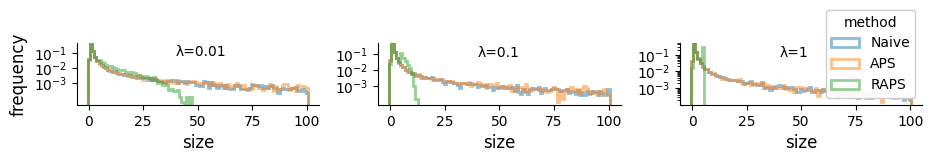

In [5]:
import itertools
seed = 0
np.random.seed(seed=seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)

### Configure experiment
modelnames = ['ResNet152']
alphas = [0.1]
predictors = ['Naive', 'APS', 'RAPS']
lamdas = [0.01, 0.1, 1] 
params = list(itertools.product(modelnames, alphas, predictors, lamdas))
m = len(params)
datasetname = 'ImagenetVal'
datasetpath = './imagenet_val/'
kreg = 5 
randomized = True
n_data_conf = 20000
n_data_val = 20000
bsz = 64
cudnn.benchmark = True

### Perform the experiment
df = pd.DataFrame(columns = ["model","predictor","size","topk","lamda"])
for i in range(m):
    modelname, alpha, predictor, lamda = params[i]
    print(f'Model: {modelname} | Desired coverage: {1-alpha} | Predictor: {predictor} | Lambda = {lamda}')
    out = sizes_topk(modelname, datasetname, datasetpath, alpha, kreg, lamda, randomized, n_data_conf, n_data_val, bsz, predictor)
    df = pd.concat([df, out], ignore_index=True)

plot_figure4(df)